![Credit: SASI SPACE - stock.adobe.com](images/fire_picture.jpeg)

# About

Using LiDAR and Environmental Justice Index data to map fire scars and identify communities disproportionately affected by the 2025 Eaton and Palisade fires.

We'll first be wrangling LiDAR data, to create our map of the fire scars. Using the same LiDAR dataset, but a different combination of bands allows us to create different types of map images. A true color image; which is probably what you're used to seeing. And a false color image; which will highlight the fire scars.

Then explore where different levels of socioeconomic factors were present within the fire perimeters. The factor we are interested in for this analysis is the Percentage of persons with income below 200% of the federal poverty level . This will be completed by wrangling the Environmental Justice Index data.

**GitHub Repository:** [https://github.com/jaslynmiura/eaton-palisades-fires-analysis](https://github.com/jaslynmiura/eaton-palisades-fires-analysis)

#### Highlights:

**Task 1:** 

- Explore geodatabases and `xarray` data

- Wrangle `xarray` data: update crs, handle NA values

- Plot false color image

**Task 2**

- Spatially join data

- Polygon clipping

- Create a choropleth map


#### Datasets:

Environmental Justice Index: Access from the Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry's Geospatial, Research, Analysis, and Services program. The dataframe contains EJI data for the state of California.

- Data Source: [EJI Data](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html)

Eaton Fire Perimeter: Accessed from the County of Los Angeles Geohub. The dataframe contains geometries of the perimeter of the Eaton fire.

- Data Source: [Palisades and Eaton Dissolved Fire Perimeters (2025)](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about)

Palisade Fire Perimeter: Accessed from the County of Los Angeles Geohub. The dataframe contains geometries of the perimeter of the Palisade fire.

- Data Source: [Palisades and Eaton Dissolved Fire Perimeters (2025)](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about)

Landsat: Accessed from the Microsof Planetary Computer data catalogue and sourced from the Landsat Collection 2 Level-2 Science Products, specifically the atmospherically corrected surface reflectance image data.

- Data Source: [USGS EROS Archive - Landsat Archives - Landsat 8-9 OLI/TIRS Collection 2 Level-2 Science Products](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-olitirs-collection-2-level-2)

- Additional Information and Metadata: [Landsat Collection 2 Surface Reflectance](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance)

#### Load Libraries and Import Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import numpy as np
import contextily as ctx

In [2]:
# Reading in the Eaton fire perimeter.
eaton_perimeter = gpd.read_file(os.path.join('data',
                                             'Eaton_Perimeter_20250121',
                                             'Eaton_Perimeter_20250121.shp'))

# Reading in the Palisades fire perimeter.
palisades_perimeter = gpd.read_file(os.path.join('data',
                                                 'Palisades_Perimeter_20250121',
                                                 'Palisades_Perimeter_20250121.shp'))

# Reading in the landsat data.
landsat = xr.open_dataset(os.path.join('data',
                                       'landsat8-2025-02-23-palisades-eaton.nc'))

# Task 1

For Task 1 we will be wrangling geodatabases and `xarray.Datasets` to create a false color image map of the Eaton and Palisades fire scars.

### Data Exploration

Before conducting an analysis, it's important to explore our datasets. In this section we'll view the first few rows of the perimeter datasets and also determine their Coordinate Reference Systems. When working with geospatial datasets, it's important to know the CRS as we want to ensure that all our datasets used within our analysis have the same CRS.

In [3]:
# Using head() to view the first 5 rows of the eaton perimeter dataframe.
eaton_perimeter.head(5)

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932..."
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831..."
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113..."
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100..."
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131..."


In [4]:
# Check the CRS of the eaton_perimeter.
print('CRS of the eaton_perimeter:', eaton_perimeter.crs)

# Check if the eaton_perimeter data is projected or geographic.
if eaton_perimeter.crs.is_projected:
    print('The eaton_perimeter has a projected CRS')
else:
    print('The eaton_perimeter has a geographic CRS')

CRS of the eaton_perimeter: EPSG:3857
The eaton_perimeter has a projected CRS


In [5]:
# Using head() to view the first 5 rows of the palisades_perimeter dataframe.
palisades_perimeter.head(5)

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,1182.082031,267.101144,"POLYGON ((-13193543.302 4032913.077, -13193543..."
1,2,Heat Perimeter,2222.488281,185.498783,"POLYGON ((-13193524.155 4033067.953, -13193524..."
2,3,Heat Perimeter,21.011719,22.412814,"POLYGON ((-13193598.085 4033158.222, -13193598..."
3,4,Heat Perimeter,214.992188,76.639180,"POLYGON ((-13193654.249 4033146.033, -13193656..."
4,5,Heat Perimeter,44203.453125,1569.259764,"POLYGON ((-13194209.580 4033236.320, -13194209..."


In [6]:
# Check the CRS of the palisades_perimeter.
print('CRS of the palisades_perimeter:', palisades_perimeter.crs)

# Check if palisades_perimeter data is projected or geographic.
if palisades_perimeter.crs.is_projected:
    print('The palisades_perimeter has a projected CRS')
else:
    print('The palisades_perimeter has a geographic CRS')

CRS of the palisades_perimeter: EPSG:3857
The palisades_perimeter has a projected CRS


**Perimeter Data Description:** 

The Eaton and Palisades perimeter data sets are very similar. They both have projected CRS, where the CRS is 'EPSG:3857'. From looking at the head of the datasets the we can see that both data sets have the same columns.

**Landsat Data**

The Landsat data is stored within an `xarray.Dataset`. Obtaining the data variables, dimensions, and coordinates of the the Landsat `xarray.Dataset` will help us fully understand the data and know how to handle the `xarray.Dataset` when creating our maps.

In [7]:
# Printing the type of the landsat data.
print('The landsat data is:', type(landsat))

# Printing the data variables of the landsat data.
print('Data variables of the landsat data:\n', landsat.data_vars)

# Printing the dimensions of the landsat data.
print('Dimensions of the landsat data:', landsat.sizes)

# Printing the coordinates of the landsat data.
print('Coordinates of the landsat data:', landsat.coords)

The landsat data is: <class 'xarray.core.dataset.Dataset'>
Data variables of the landsat data:
 Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...
Dimensions of the landsat data: Frozen({'y': 1418, 'x': 2742})
Coordinates of the landsat data: Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...


**Landsat Data Description:** 

The Landsat data is an `xarray.Dataset`. The data variables of the `xarray.Dataset` are red, green, blue, near-infrared, short-wave infrared, and spatial reference. Red, green, blue, near-infrared, and short-wave infrared are the bands that are a part of satellite data collection. The spatial reference variable holds information about the dataset, such as the CRS. The dimensions of the `xarray.Dataset` are {'y': 1418, 'x': 2742}, meaning there are 1418 rows and 2742 columns of pixels. The coordinates of the `xarray.Dataset` are given as y and x as lists, where the starting coordinates provided are 3.799e+06 and 3.344e+05, respectively. A single time coordinate is provided too, which represents the time at which the Landsat data was collected.

#### Landsat xarray data wrangling

During the data exploration, we noticed that the CRS of the `xarrary.Dataset` is stored in the spatial reference variable. In the following section we'll see that while the CRS may be documented within the `xarray.Dataset`, it cannot be referenced through the `rio.crs` function. Therefore, we want to restore the CRS.

In [8]:
# Printing the CRS of the landsat data.
print('The current CRS of the landsat data:', landsat.rio.crs)

The current CRS of the landsat data: None


In [9]:
# Printing the CRS of the landsat data, which is stored in the spatial_ref variable.
print('CRS:', landsat.spatial_ref.crs_wkt)

CRS: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


Here we use `.spatial_ref.crs_wkt` to reference the CRS stored in the spatial reference variable. We can use `rio.write_crs()` to update the `landsat`'s CRS.

In [10]:
# Setting the crs of the landsat data.
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)

In [11]:
# Checking that the CRS of the landsat data was updated.
print('The current CRS of the landsat data:', landsat.rio.crs)

The current CRS of the landsat data: EPSG:32611


#### Create a True Color Image Map

A true color image is one that represents what the human eye would see from an aerial view. True color images are created when the sensor's red, green, and blue bands are assigned to their corresponding color channels. Since true color images mirror what we see, we can use our intuition to identify vegetation and urban areas.

We'll create a true color image of the Eaton and Palisades fire scars. Because this is an image of the region **after** the fires occurred, we can expect the area where the fires occurred to be brown or bare, representing a loss of greenery or vegetation.

However, we'll notice that through the true color image it is hard to identify the fire scars.

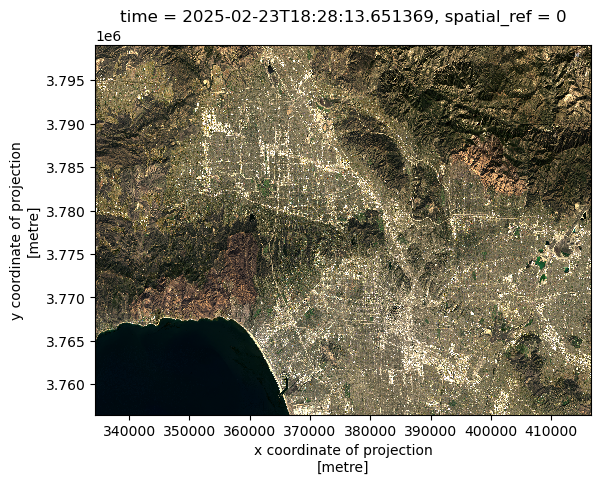

In [12]:
# Replacing NA values with 0 and plotting the landsat data.
landsat[['red', 'green', 'blue']].fillna(0).to_array().plot.imshow(robust=True)

Cloud cover can create extreme outliers that cause the other values within the landsat data to be squished when plotting, which makes a plot appear "empty". By setting `imshow(robust=True)` this ignores the cloud cover values. We also want replacing any `nan` values with 0 by using `fillna()`. By doing these two steps, this returns an optimal color scale for our true color image

#### Create a False Color Image

A false color image is one that assigns the short-wave infrared, near-red infrared, and red bands are red, green, and blue color channels, respectfully. In doing so, this image highlights features that are difficult to detect within a true color image, such as the fire scars.

Combining the fire perimeter boundaries and the false color image we can create a map that distinguishes the Eaton and Palisades fire scars.

Since we'll be combining the fire perimeter boundaries and the Landsat data on a single map, we'll first want to ensure that they use the same CRS.

In [13]:
# Checking that the perimeter CRS and the landsat CRS are the same.
eaton_perimeter = eaton_perimeter.to_crs(landsat.rio.crs)
palisades_perimeter = palisades_perimeter.to_crs(landsat.rio.crs)
print(f"CRS of eaton_perimeter matches CRS of landsat CRS:", eaton_perimeter.crs == landsat.rio.crs)
print(f"CRS of palisades_perimeter matches CRS of landsat CRS:", palisades_perimeter.crs == landsat.rio.crs)

CRS of eaton_perimeter matches CRS of landsat CRS: True
CRS of palisades_perimeter matches CRS of landsat CRS: True


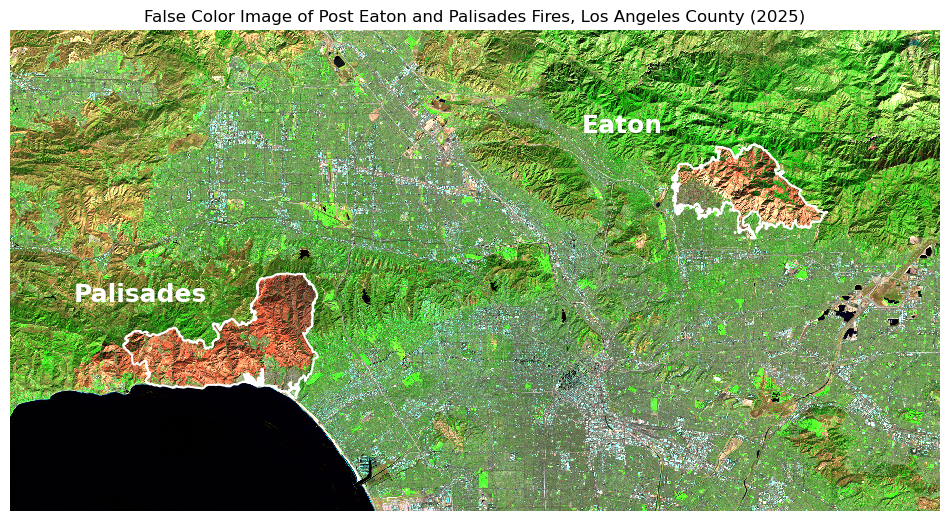

In [14]:
# Create false color image/map.
fig, ax=plt.subplots(figsize=(12,10))

# Remove the axis for a cleaner map
ax.axis('off')

landsat[['swir22', 'nir08', 'red']].fillna(0).to_array().plot.imshow(
    ax=ax,
    robust=True)

palisades_perimeter.plot(ax=ax,
               edgecolor='white',
               facecolor='none',
               linewidth= 1.5)
eaton_perimeter.plot(ax=ax,
               edgecolor='white',
               facecolor='none',
               linewidth= 1.5)

ax.text(x=340000,
         y=3775000,
         s='Palisades',
         color='white',
         fontsize=18,
         weight='bold')

ax.text(x=385000,
        y=3790000,
        s='Eaton',
        color='white',
        fontsize=18,
        weight='bold')

plt.title('False Color Image of Post Eaton and Palisades Fires, Los Angeles County (2025)')

plt.show()

# Task 2

For Task 2 we will be relating Environmental Justice Index (EJI) census data to our fire perimeters to understand the distribution of a given socioeconomic variable within the area of the fires, which will be visualized through a choropleth map.

#### Import EJI Data

In [15]:
eji = gpd.read_file(os.path.join('data',
                                 'EJI_2024_United_States',
                                 'EJI_2024_United_States.gdb'))

To spatially join the perimeters to the EJI data, both datasets must have the same Coordinate Reference System.

In [16]:
# Checking that the perimeter data matches the CRS of the eji data.
eji = eji.to_crs('EPSG:3857')
eaton_perimeter = eaton_perimeter.to_crs('EPSG: 3857')
palisades_perimeter = palisades_perimeter.to_crs('EPSG: 3857')
print(f"CRS of eaton_perimeter matches eji CRS:", eaton_perimeter.crs == eji.crs)
print(f"CRS of palisades_perimeter matches eji CRS:", palisades_perimeter.crs == eji.crs)

CRS of eaton_perimeter matches eji CRS: True
CRS of palisades_perimeter matches eji CRS: True


#### Spatially Join Perimeters and EJI Data

Since we are working with `geodatasets`, we'll want to use `geopandas.sjoin()`, to **spatially** join the datasets. This will be done using the geometry column of both datasets to complete an inner join of the EJI and perimeters data. This will return the EJI census tracts that intersect the fire perimeters. 

In [17]:
# Inner join the eji and perimeter datasets on the geometry column.
eaton_eji = gpd.sjoin(eji, eaton_perimeter)
palisade_eji = gpd.sjoin(eji, palisades_perimeter)

By plotting the joined data, we can see that any EJI census tract that intersects, meaning it is within or touches the red fire perimeter, was kept in our join. Therefore, we have census tract areas that are outside the scope of our fire perimeters.

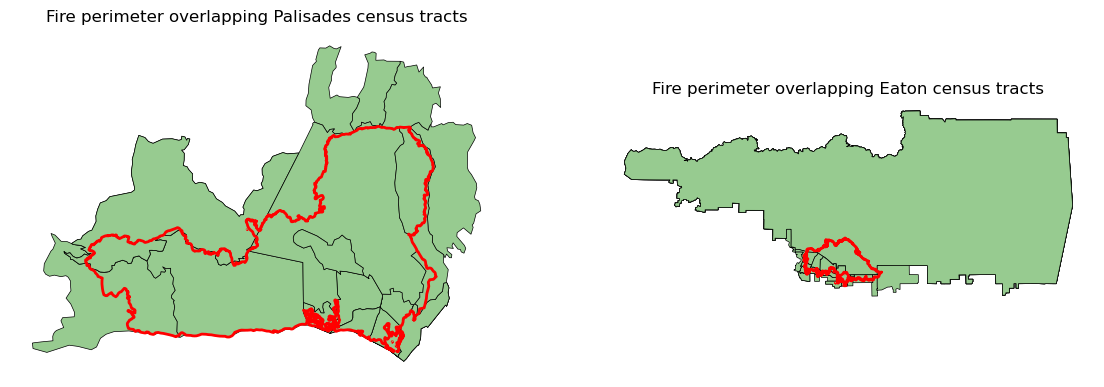

In [26]:
# Plot the fire perimeters on the Eaton and Palisade census tracts.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

palisade_eji.plot(ax=ax1, 
                  color= '#97CB90',
                  edgecolor='black',
                  linewidth=0.5)
palisades_perimeter.plot(ax=ax1, 
              edgecolor= 'red', 
              color = 'none', 
              linewidth=2)
ax1.axis('off')

ax1.set_title('Fire perimeter overlapping Palisades census tracts')

eaton_eji.plot(ax=ax2, 
               color= '#97CB90',
               edgecolor='black',
               linewidth=0.5)
eaton_perimeter.plot(ax=ax2, 
              edgecolor= 'red', 
              color = 'none', 
              linewidth=2)
ax2.axis('off')

ax2.set_title('Fire perimeter overlapping Eaton census tracts')

plt.show()

#### Polygon Clipping

Since our study area is within the Eaton and Palisades fire perimeters, we can clip the intersecting census tracts to the perimeters usings `geopandas.clip()`.  This will return the portions of the census tracts that lie **within** the fire perimeters, which is displayed in the the plot.

In [19]:
# Clip the census tracts to the Eaton and Palisade fire perimeters.
palisade_eji_clip = gpd.clip(palisade_eji, palisades_perimeter)
eaton_eji_clip = gpd.clip(eaton_eji, eaton_perimeter)

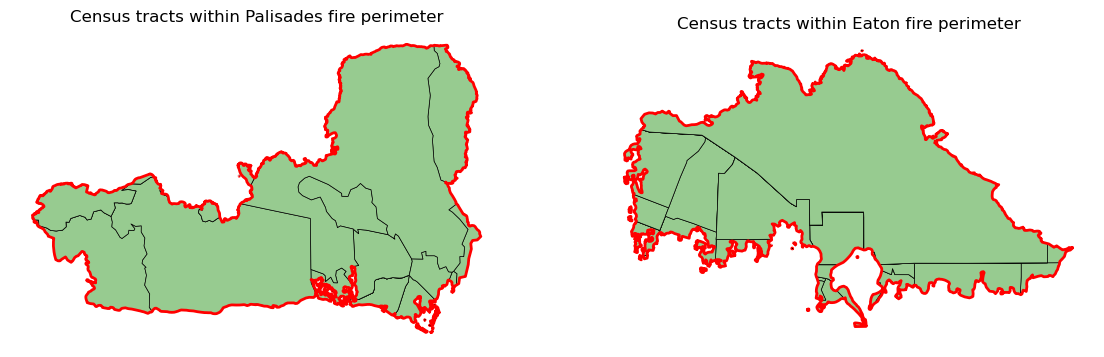

In [27]:
# Plot the fire perimeters on the Eaton and Palisade census tracts.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

palisade_eji_clip.plot(ax=ax1, 
                  color= '#97CB90',
                  edgecolor='black',
                  linewidth=0.5)
palisades_perimeter.plot(ax=ax1, 
              edgecolor= 'red', 
              color = 'none', 
              linewidth=2)
ax1.axis('off')

ax1.set_title('Census tracts within Palisades fire perimeter')

eaton_eji_clip.plot(ax=ax2, 
               color= '#97CB90',
               edgecolor='black',
               linewidth=0.5)
eaton_perimeter.plot(ax=ax2, 
              edgecolor= 'red', 
              color = 'none', 
              linewidth=2)
ax2.axis('off')

ax2.set_title('Census tracts within Eaton fire perimeter')

plt.show()

#### Create a Choropleth 

Using `E_POV200`, which represents the percentage of persons with income below 200% of the federal poverty level. We'll create a choropleth map to visualize the distribution of percentage of persons with income below 200% of the federal poverty level, within the fire perimeters.

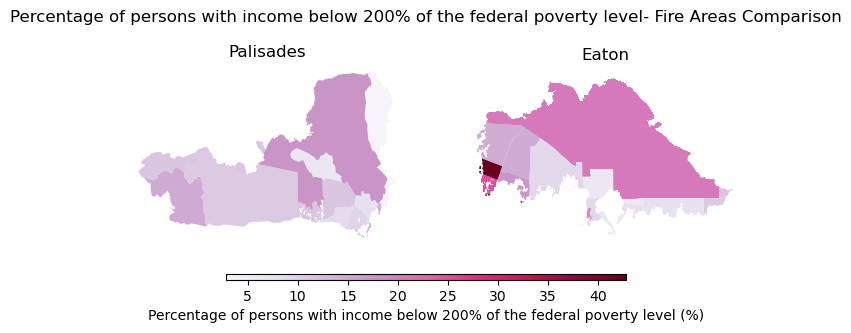

In [21]:
# Create a choropleth map.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Selecting the variable to be 'Percentage of persons with income below 200% of the federal poverty level'
eji_variable = 'E_POV200'

# Find common min/max for legend range
vmin = min(palisade_eji_clip[eji_variable].min(), palisade_eji_clip[eji_variable].min())
vmax = max(eaton_eji_clip[eji_variable].max(), eaton_eji_clip[eji_variable].max())

# Plot census tracts within Palisades perimeter
palisade_eji_clip.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    cmap = 'PuRd',
    ax=ax1,
)
ax1.set_title('Palisades')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eaton_eji_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    cmap = 'PuRd',
    ax=ax2,
)
ax2.set_title('Eaton')
ax2.axis('off')

# Add overall title
fig.suptitle('Percentage of persons with income below 200% of the federal poverty level- Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable(cmap='PuRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage of persons with income below 200% of the federal poverty level (%)')

plt.show()

The choropleth map shows a mixed distribution of percentage of persons with income below 200% of the federal poverty level (%) within the Palisades fire perimeter. The map indicates that within the perimeter the range of percentage of persons with income below 200% of the federal poverty level is about <5% to 20%. The Eaton perimeter holds a larger range of percentages at <5% to 40%, with a large section of the census tracts within the fire perimeter appearing to be categorized as roughly 25% of persons with income below 200% of the federal poverty level. This could likely be due to the fact that this census tract sits on a less densely populated mountain side, where percentage estimates become more sensitive to outliers. 

These choropleth maps provide a tool for others to decide where relief and recovery resources should be prioritized. While fires can impact all residents, certain socioeconomic factors, such as a high percentage of persons with income below 200% of the federal poverty level can make relief and recovery from a fire more difficult. Understanding the spatial distribution of social vulnerabilities will help equitable response and recovery for future fires.

## References

Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. [Year] Environmental Justice Index. Accessed [2025-11-21]. [https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html](https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html)

County of Los Angeles, Geohub. (2025). Palisades and Eaton Dissolved Fire Perimeters (2025) [dataset]. County of Los Angeles. [https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about)

Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. [https://doi.org/10.5066/P9OGBGM6](https://doi.org/10.5066/P9OGBGM6)
